## Загружаем библиотеки и соревнования с kaggle



In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


In [ ]:
!mkdir -p ~/.kaggle  #создает директорию внутри пути
!touch ~/.kaggle/kaggle.json  #создание нового пустого файла
!chmod 600 ~/.kaggle/kaggle.json #изменение разрешения доступа к файлу. 600 означает, что личный файл может быть изменен только пользователем, который ввел эту команду.

# сюда задайте свой нейм и токен
!echo '{"username":"", "key":""}' > ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c denoising-dirty-documents #загрузка соревнования с kaggle

 53% 5.00M/9.39M [00:00<00:00, 45.7MB/s]
100% 9.39M/9.39M [00:00<00:00, 60.3MB/s]
 73% 16.0M/21.9M [00:00<00:00, 167MB/s]
100% 21.9M/21.9M [00:00<00:00, 140MB/s]
  0% 0.00/6.30M [00:00<?, ?B/s]
100% 6.30M/6.30M [00:00<00:00, 58.0MB/s]
 49% 9.00M/18.5M [00:00<00:00, 69.5MB/s]
100% 18.5M/18.5M [00:00<00:00, 90.7MB/s]


In [ ]:
!unzip -q train.zip  #разархивирование выборки
!ls train | wc -l

!unzip -q test.zip
!ls test | wc -l

!unzip -q train_cleaned.zip
!ls test | wc -l

144
72
72


In [ ]:
import os
WIDTH = 540
HEIGHT = 420
n_total = 144 # total images
n = int(0.7*n_total) # train images
images = []
PIC_DIR = 'train/'
for path in tqdm(os.listdir(PIC_DIR)[:n_total]):
    pic = Image.open(PIC_DIR + path)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    if np.asarray(pic).shape[0] == 258:
      pic = np.pad(pic, [(81,81),(0,0)], 'constant', constant_values=(255, 255))
    images.append(np.uint8(pic)/255.)
images = np.stack(images)
images.shape

100%|██████████| 144/144 [00:00<00:00, 215.79it/s]


(144, 420, 540)

In [ ]:
WIDTH = 540
HEIGHT = 420
n_total = 144 # total images
n = int(0.7*n_total) # train images
images_clean = []
PIC_DIR1 = 'train_cleaned/'
for path in tqdm(os.listdir(PIC_DIR1)[:n_total]):
    pic = Image.open(PIC_DIR1 + path)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    if np.asarray(pic).shape[0] == 258:
      pic = np.pad(pic, [(81,81),(0,0)], 'constant', constant_values=(255, 255))
    images_clean.append(np.uint8(pic)/255.)
images_clean = np.stack(images_clean)
images_clean.shape

100%|██████████| 144/144 [00:00<00:00, 444.96it/s]


(144, 420, 540)

In [ ]:
from tensorflow import keras
# задаём callback на каждую эпоху с использованием fix_batch
class ReconstuctionCallback(keras.callbacks.Callback):
    def __init__(self, model, fixed_images=images[:]):
        self.model = model
        self.fixed_images = fixed_images[:]

    def on_epoch_end(self, epoch=0, logs=None):
        pred = self.model.predict(self.fixed_images)
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        plt.axis('off')
        im = ax.imshow(np.concatenate(np.concatenate([self.fixed_images, pred, (self.fixed_images-pred + 1)/2], axis=1), axis=1))
        plt.show()

class EvaluateCallback(keras.callbacks.Callback):
    def __init__(self, model, val_data):
        self.val_data = val_data
        self.model = model

    def on_epoch_end(self, epoch=1, logs=None):
        for name, data in self.val_data.items():
            if type(data) is not tuple:
                data = (data, data)
            res = self.model.evaluate(data[0], data[1], verbose = 0)
            print(f'Loss on {name}:', round(res, 4))

Задаем архитектуру, которая состоит из энкодера и декодера


In [ ]:
import keras
from keras import layers, optimizers, Model
# Задаём архитектуру нашей нейросети автоэнкодера
input_img = keras.Input(shape=(420, 540, 1))
batch_size = 4
# encoder
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', batch_size = 4)(input_img)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same', batch_size = 4)(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = layers.BatchNormalization()(x)

encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# decoder
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
encoder = keras.Model(input_img, encoded)

from keras import backend as K
def root_mean_squared_error(images, images_clean):
        return K.sqrt(K.mean(K.square(images - images_clean))) 


autoencoder.compile(optimizer='Adam', loss = root_mean_squared_error) 
# encoder.summary()
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 420, 540, 64)      640       
_________________________________________________________________
batch_normalization_4 (Batch (None, 420, 540, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 210, 270, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 210, 270, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 105, 135, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 105, 135, 64)      3692

In [ ]:
autoencoder.fit(
    images[:],
    images_clean[:],
    batch_size=6,
    epochs=60,
    # callbacks=[
    #     EvaluateCallback(autoencoder, {
    #         'loss train good': (images[:], images_clean[:]),
    #         'loss val good': (images[:], images[:]),
    #         'loss train noisy': (images_clean[:], images[:]),
    #         'loss val noisy': (images_clean[:], images[:]),
    #     }),
    #     ReconstuctionCallback(autoencoder, images)
    # ]
);

Epoch 1/15
5/5 [==============================] - 230s 44s/step - loss: 0.1473
Epoch 2/15
5/5 [==============================] - 230s 45s/step - loss: 0.1320
Epoch 3/15
5/5 [==============================] - 232s 45s/step - loss: 0.1150
Epoch 4/15
5/5 [==============================] - 232s 45s/step - loss: 0.1032
Epoch 5/15
5/5 [==============================] - 232s 45s/step - loss: 0.0936
Epoch 6/15
5/5 [==============================] - 229s 44s/step - loss: 0.0825
Epoch 7/15
5/5 [==============================] - 228s 44s/step - loss: 0.0836
Epoch 8/15
5/5 [==============================] - 230s 45s/step - loss: 0.0905
Epoch 9/15
5/5 [==============================] - 229s 44s/step - loss: 0.0751
Epoch 10/15
5/5 [==============================] - 229s 45s/step - loss: 0.0768
Epoch 11/15
5/5 [==============================] - 229s 44s/step - loss: 0.0737
Epoch 12/15
5/5 [==============================] - 229s 45s/step - loss: 0.0824
Epoch 13/15
5/5 [==============================] 

In [ ]:
from tqdm import tqdm
import os
WIDTH = 540
HEIGHT = 420
n_total = 144 # total images
n = int(0.7*n_total) # train images
test = []
PIC_DIR2 = 'test/'
for path in tqdm(os.listdir(PIC_DIR2)[:n_total]):
    pic = Image.open(PIC_DIR2 + path)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    if np.asarray(pic).shape[0] == 258:
      pic = np.pad(pic, [(81,81),(0,0)], 'constant', constant_values=(255, 255))
    test.append(np.uint8(pic)/255.)
test = np.stack(test)
test.shape

100%|██████████| 72/72 [00:00<00:00, 285.08it/s]


(72, 420, 540)

In [ ]:
images_predicted=(autoencoder.predict(test)).reshape(72, 420, 540)

In [ ]:
test=test.ravel()

In [ ]:
test.shape

(72, 420, 540)

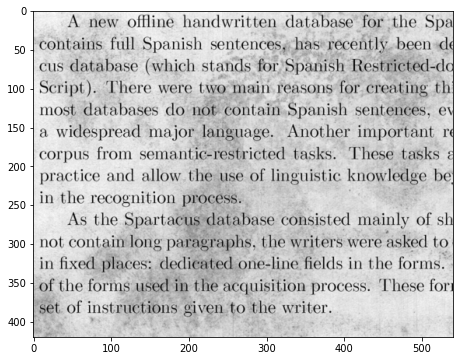

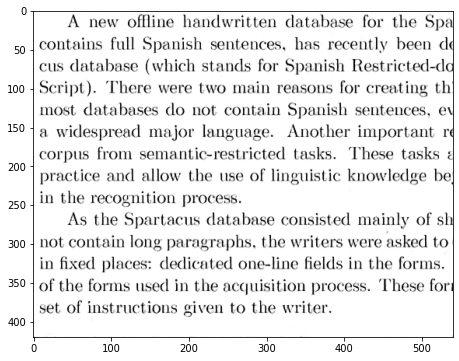

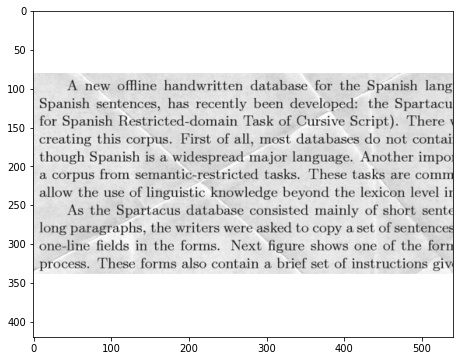

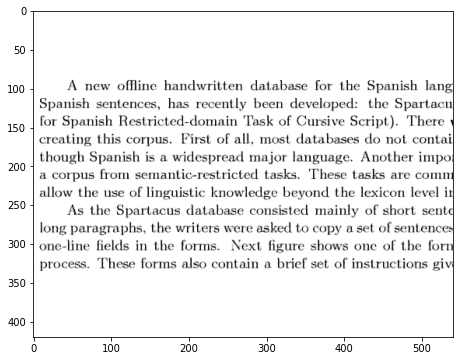

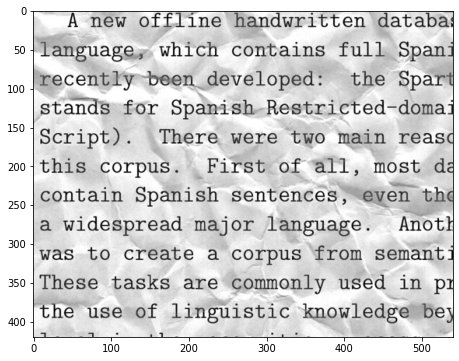

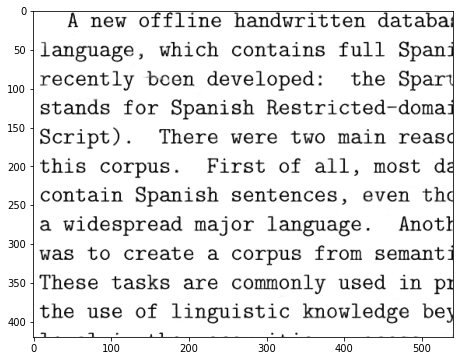

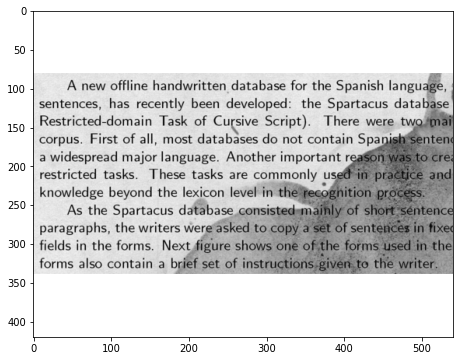

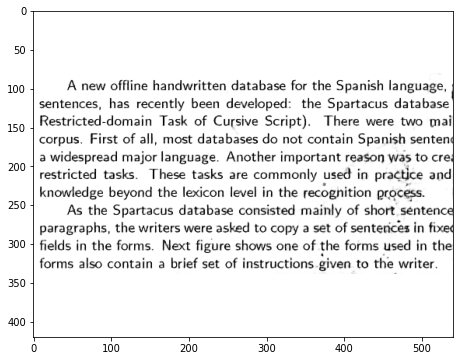

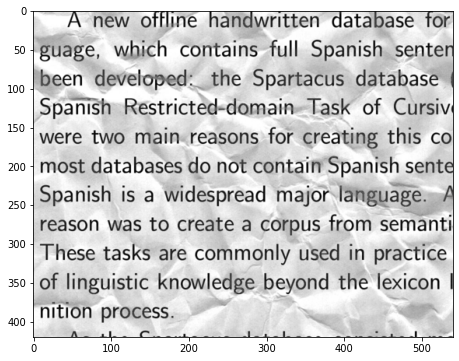

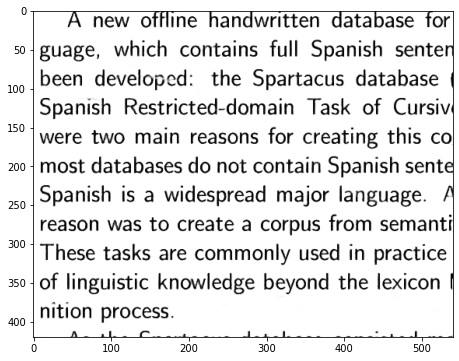

In [ ]:
for i in range(5):
    plt.figure(figsize=(12,6))
    plt.imshow(test[i],cmap='gray')
    plt.figure(figsize=(12,6))
    plt.imshow(images_predicted[i],cmap='gray')

In [ ]:
path = '/content/'

In [ ]:
import cv2
ids = []
vals = []
for i, f in enumerate(os.listdir(path + 'test')):
    file = path + 'test/' + f
    imgid = int(f[:-4])
    img = cv2.imread(file, 0)
    img_shape = img.shape
    print('Processing image: {} \tinto size: {}'.format(f, img_shape))  
    preds_reshaped = cv2.resize(images_predicted[i], (img_shape[1], img_shape[0]))
    for r in range(img_shape[0]):
        for c in range(img_shape[1]):
            ids.append(str(imgid)+'_'+str(r + 1)+'_'+str(c + 1))
            vals.append(preds_reshaped[r, c])
submission = pd.DataFrame({'id': ids, 'value': vals})
submission.to_csv('submission.csv',index = False)
print('Results saved to submission.csv!')
# quick check if length of IDs is OK
# we should get there number 14230080
print('Length of IDs: {}'.format(len(ids)))

Processing image: 163.png 	into size: (420, 540)
Processing image: 16.png 	into size: (258, 540)
Processing image: 142.png 	into size: (420, 540)
Processing image: 37.png 	into size: (258, 540)
Processing image: 118.png 	into size: (420, 540)
Processing image: 97.png 	into size: (420, 540)
Processing image: 112.png 	into size: (420, 540)
Processing image: 94.png 	into size: (420, 540)
Processing image: 19.png 	into size: (258, 540)
Processing image: 46.png 	into size: (258, 540)
Processing image: 67.png 	into size: (258, 540)
Processing image: 127.png 	into size: (420, 540)
Processing image: 1.png 	into size: (258, 540)
Processing image: 196.png 	into size: (420, 540)
Processing image: 7.png 	into size: (258, 540)
Processing image: 136.png 	into size: (420, 540)
Processing image: 115.png 	into size: (420, 540)
Processing image: 211.png 	into size: (420, 540)
Processing image: 55.png 	into size: (258, 540)
Processing image: 85.png 	into size: (420, 540)
Processing image: 106.png 	into s

In [ ]:
my_submission = pd.read_csv('submission.csv')
my_submission.head(5)

,id,value
0,163_1_1,250.360977
1,163_1_2,254.376358
2,163_1_3,253.833115
3,163_1_4,254.185623
4,163_1_5,253.196014


In [ ]:
ids = []
vals = []
for i, f in enumerate(TEST_IMAGES):
    file = os.path.basename(f)
    imgid = int(file[:-4])
    test_img = cv2.imread(f, 0)
    img_shape = test_img.shape
    print('processing: {}'.format(imgid))
    print(img_shape)
    preds_reshaped = cv2.resize(preds[i], (img_shape[1], img_shape[0]))
    for r in range(img_shape[0]):
        for c in range(img_shape[1]):
            ids.append(str(imgid)+'_'+str(r + 1)+'_'+str(c + 1))
            vals.append(preds_reshaped[r, c])

print('Writing to csv file')
pd.DataFrame({'id': ids, 'value': vals}).to_csv('submission.csv', index=False)